In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -av "/content/drive/MyDrive/SIV Project Data" "/content/Project Data"

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

def fillmissing(data):
    for col in data.columns:
        if data[col].isna().sum() > 0:
            data[col].fillna(0, inplace=True)
    return data

def encode(data, columns_list):
    data = pd.get_dummies(data, columns = columns_list)
    return data

def drop_columns(data, columns_list):
    data = data.drop(columns_list, axis = 1)
    return data

def binarize_columns(data, columns_list):
    for col in columns_list:
        data[col] = data[col].astype(int)
    return data

def generate_ip_attribute(data):
    temp = data['ip'].apply(lambda x: ".".join(x.split('.')[:1]))
    vc = temp.value_counts()
    data['ip'] = temp.apply(lambda x: x if vc[x]>150 else "other")
    return data

def class_resampling(X, y):
    from imblearn.over_sampling import RandomOverSampler

    ros = RandomOverSampler(random_state=42)

    # fit predictor and target variable
    x_ros, y_ros = ros.fit_resample(X, y)

    return x_ros, y_ros

train_data = pd.read_csv('./cybersecurity_training.csv', delimiter="|", header=[0])

train_data = fillmissing(train_data)

# for col in train_data.columns:
#     print(col, train_data[col].dtype)

binary_columns_list = [ 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10']
useless_columns_list = ['client_code', 'alert_ids']
one_hot_encode_columns_list = ['ip', 'categoryname', 'ipcategory_name', 'ipcategory_scope', 'parent_category', 'grandparent_category', 'weekday', 'dstipcategory_dominate', 'srcipcategory_dominate']

# Adding new attribute ip_prefix
train_data = generate_ip_attribute(train_data)

train_data = encode(train_data, one_hot_encode_columns_list)
train_data = drop_columns(train_data, useless_columns_list)
train_data = binarize_columns(train_data, binary_columns_list)



0    26005
1     1593
Name: notified, dtype: int64
(array([0, 1]), array([26005, 26005]))
ROC AUC score 0.760601
Average precision score 0.195958
Mean Squared error 0.352016
Macro F1 score 0.48963
Micro F1 score 0.647984


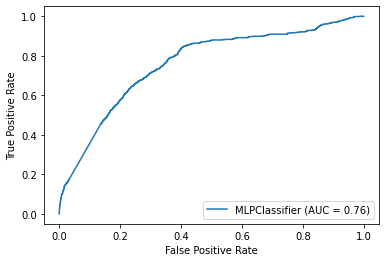

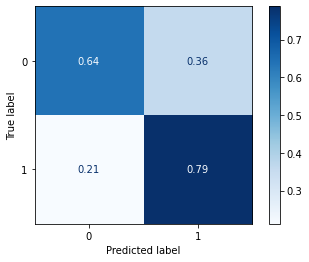

In [ ]:
###   NEURAL NETWORKS

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

y = train_data['notified']
X = train_data.drop('notified', axis=1)
test_split_size = 0.3
seed = 1011

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_size, random_state=1010, shuffle=True, stratify = y)

print(y_train.value_counts())

X_train, y_train = class_resampling(X_train, y_train)

print(np.unique(y_train, return_counts=True))


model = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(10, 30, 10), random_state=seed, activation='relu', max_iter=1000, learning_rate= 'adaptive')
model.fit(X_train, y_train)

predictions = model.predict_proba(X_test)
y_pred = model.predict(X_test)

print("ROC AUC score", round(metrics.roc_auc_score(y_test, predictions[:,1]),6))
print("Average precision score", round(metrics.average_precision_score(y_test, predictions[:,1]),6))

print("Mean Squared error", round(metrics.mean_squared_error(y_test, y_pred),6))
print("Macro F1 score", round(metrics.f1_score(y_test, y_pred, average='macro'),6))
print("Micro F1 score", round(metrics.f1_score(y_test, y_pred, average='micro'),6))

metrics.plot_roc_curve(model, X_test, y_test)  
plt.savefig("nn_roc.png") 

metrics.plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')  
plt.savefig("nn_confussion.png")

In [ ]:
from sklearn.model_selection import GridSearchCV

mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X, y) # X is train samples and y is the corresponding labels

print('Best parameters found:\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

y_true, y_pred = y_test , clf.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.942 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
0.943 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}
0.942 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.942 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.942 (+/-0.000) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.943 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}
0.942 